In [1]:
"""
transformer的实现
http://nlp.seas.harvard.edu/2018/04/03/attention.html
https://jalammar.github.io/illustrated-transformer/

"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
from IPython.display import Image
%matplotlib inline

import sys
sys.path.append("../common/")
import model_utils
import time_utils

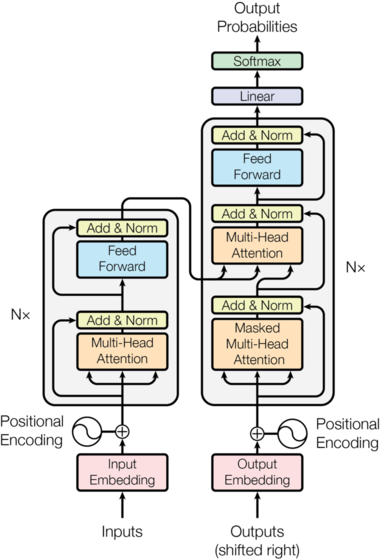

In [2]:
Image(filename='images/transformer_high_level.png')

In [3]:
def clones(module, N):
    """
    encoder和decoder的stack
    产生N个同一样的层
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class EncoderDecoder(nn.Module):
    """
    transformer的高层结构
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        # embed 根据最后的code，既有embedding也有positional encoding。
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

"""
model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        # word embedding + positional encoding
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)) 
"""

'\nmodel = EncoderDecoder(\n        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),\n        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),\n        # word embedding + positional encoding\n        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),\n        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),\n        Generator(d_model, tgt_vocab)) \n'

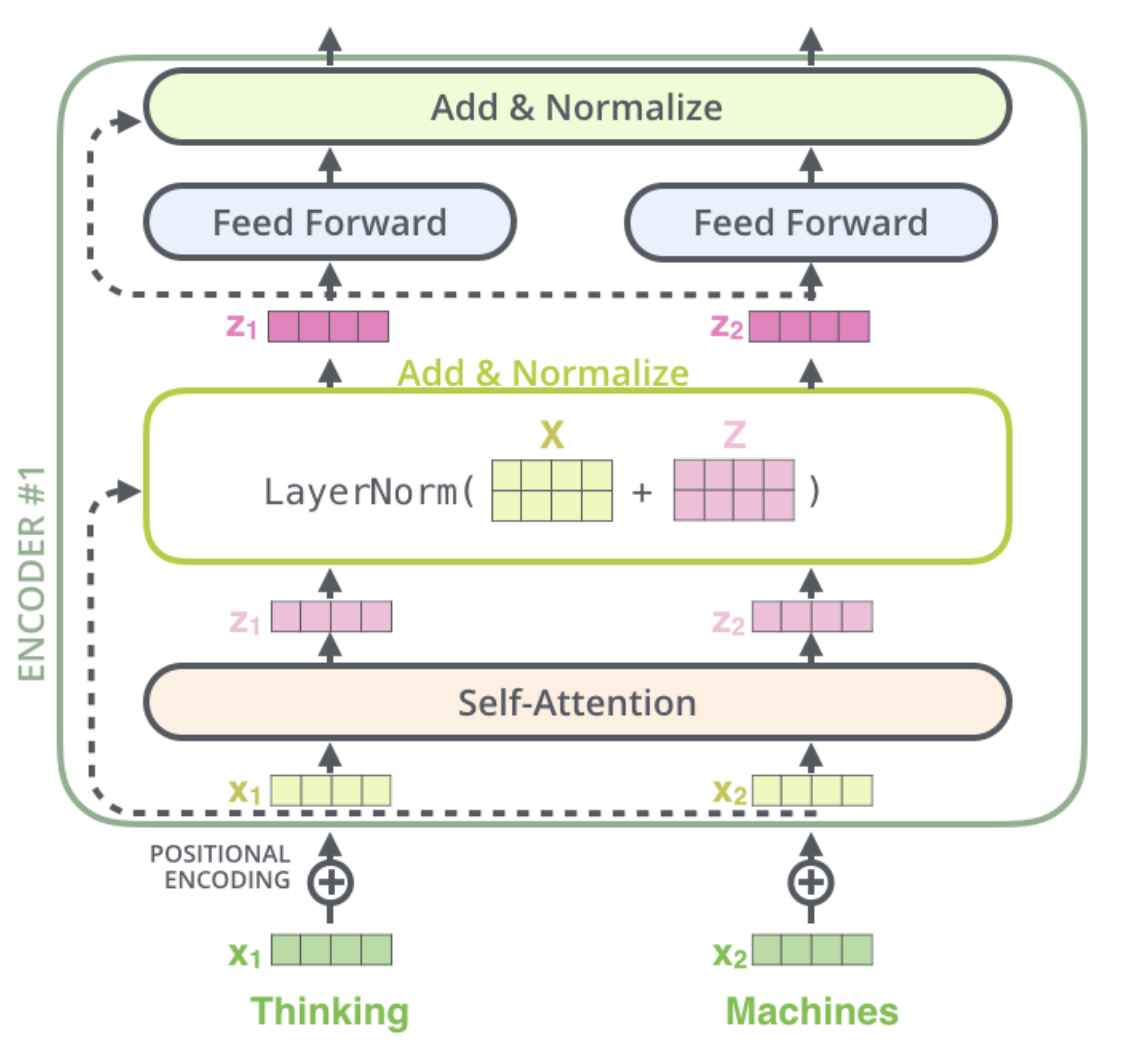

In [4]:
Image(filename='images/transformer_encoder_norm.png', width=300, unconfined=True)

In [5]:
class LayerNorm(nn.Module):
    # Normalization，感觉这个跟feature的norm类似，只是这里norm的针对于一个向量
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        """
        这个好像跟图上有一些不一样。图上的感觉是
        return self.norm(x + self.dropout(sublayer(x)))
        
        """
        return x + self.dropout(sublayer(self.norm(x)))


class PositionwiseFeedForward(nn.Module):
    """
    encoder/decoder都用到的FN。输入和输出是一样维度的。
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))  

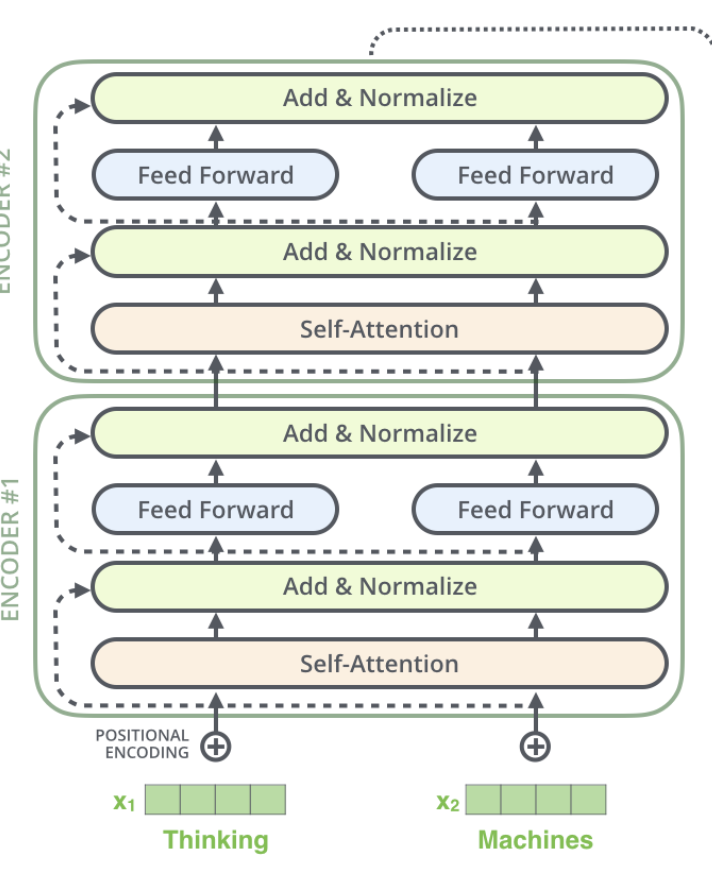

In [6]:
Image(filename='images/transformer_encoder_layers.png', width=300, unconfined=True)

In [7]:
# Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N)
"""
EncoderDecoder.forward()-> 
EncoderDecoder.encode()->
Encoder.forawrd()->
    EncoderLayer.forward()->
        SublayerConnection.forward()->
        LayerNorm.forward()->
        MultiHeadedAttention.forward() return
    EncoderLayer.forward()->
        SublayerConnection.forward()->
        LayerNorm.forward()->
        PositionwiseFeedForward.forward() return
    EncoderLayer.forward() return
LayerNorm.forward()
"""
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        """
        这里好像有跟上面有一些不同，上图中一个layer由一个self-attention和一个FFNN组成，每层输出都要norm一下。
        但是这里好像是经过了self-attention+FFNN才norm一下。
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


class EncoderLayer(nn.Module):
    """
    定义了Encoder的一层。
    """
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        """
        调用的是MultiHeadedAttention的forward函数。
        forward(self, query, key, value, mask=None)
        """
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

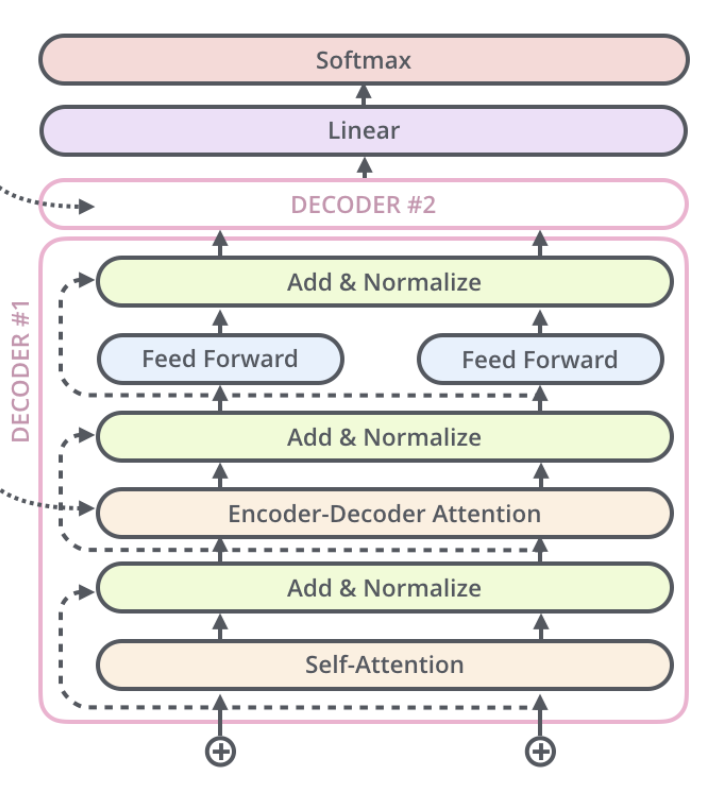

In [8]:
Image(filename='images/transformer_decoder.png', width=300, unconfined=True)

In [9]:
# Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N)
"""
不同点在于：
1. decoder的layer比encoder多一个input/output的attention(src_attn)，接受的是encoder的输出
2. 有mask了。
EncoderDecoder.forward()-> 
EncoderDecoder.decode()->
Decoder.forawrd()->
    DecoderLayer.forward()->
        SublayerConnection.forward()->
        LayerNorm.forward()->
        MultiHeadedAttention.forward() return
    DecoderLayer.forward()->
        SublayerConnection.forward()->
        LayerNorm.forward()->
        MultiHeadedAttention.forward() return
    DecoderLayer.forward()->
        SublayerConnection.forward()->
        LayerNorm.forward()->
        PositionwiseFeedForward.forward() return
    DecoderLayer.forward() return
LayerNorm.forward()
"""
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        memory是什么？
        从EncoderDecoder的这行调用看出
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
        memory其实就是Encoder.forward()的输出，所以它就是原始input在最上层的那个encoder
        编码后的输出。同时可以看见，decoder的每一层都用了这个memory。
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        # decoder先自己计算一下attention，注意这个mask传入是有值的。
        # scores在decoder的mask的方式是给attention score一个很小的值。
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        # 计算与encoder最终输出的各个word的encoding的attention得分，src_mask全为True，不mask
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)


class Generator(nn.Module):
    """
    decoder最后的输出层。
    """
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

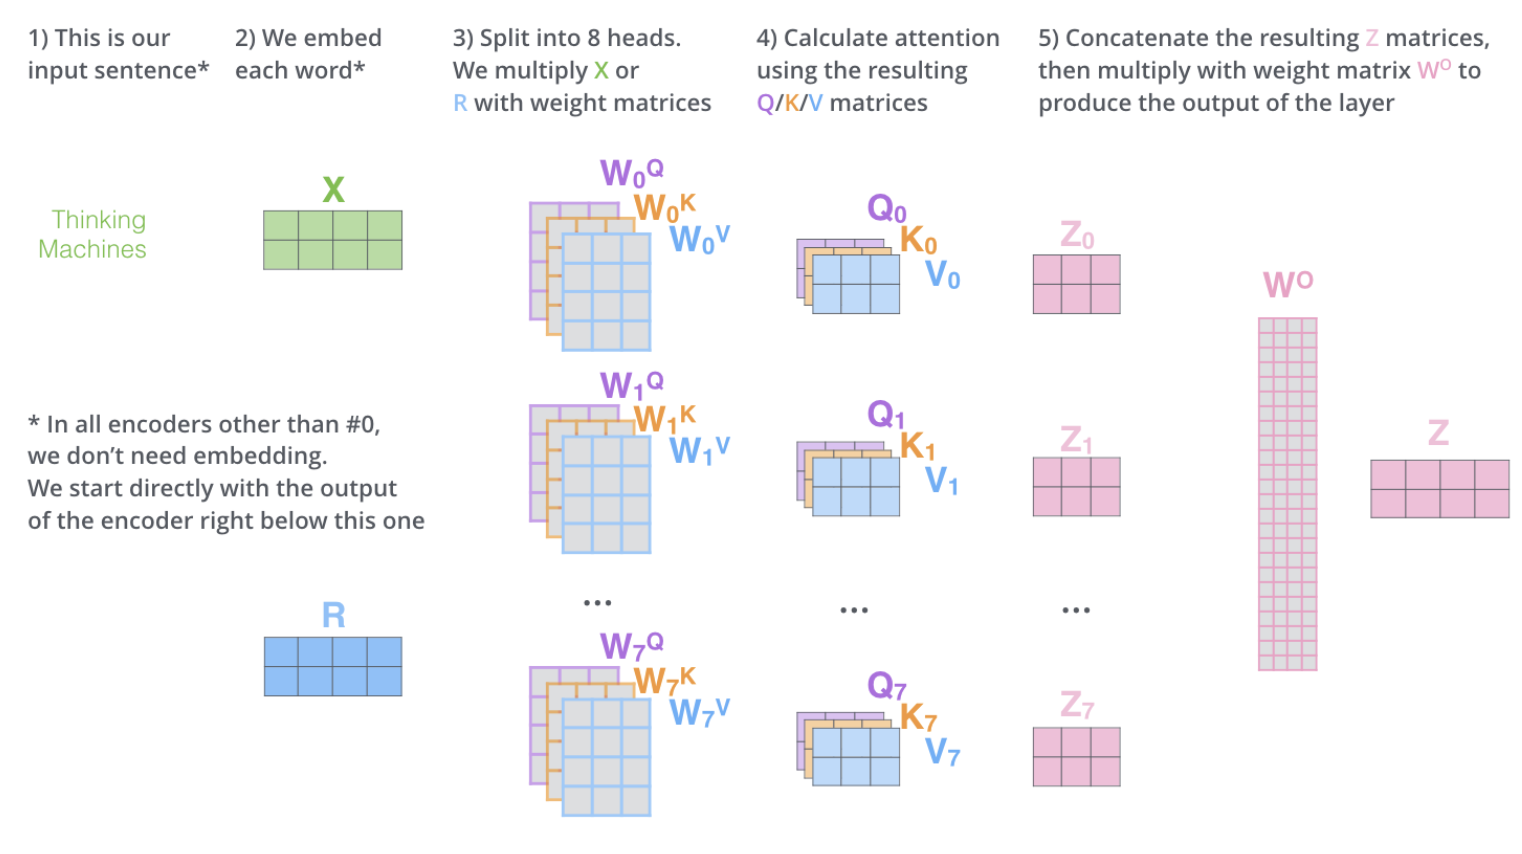

In [10]:
Image(filename='images/multi_head_attention.png', width=500, unconfined=True)

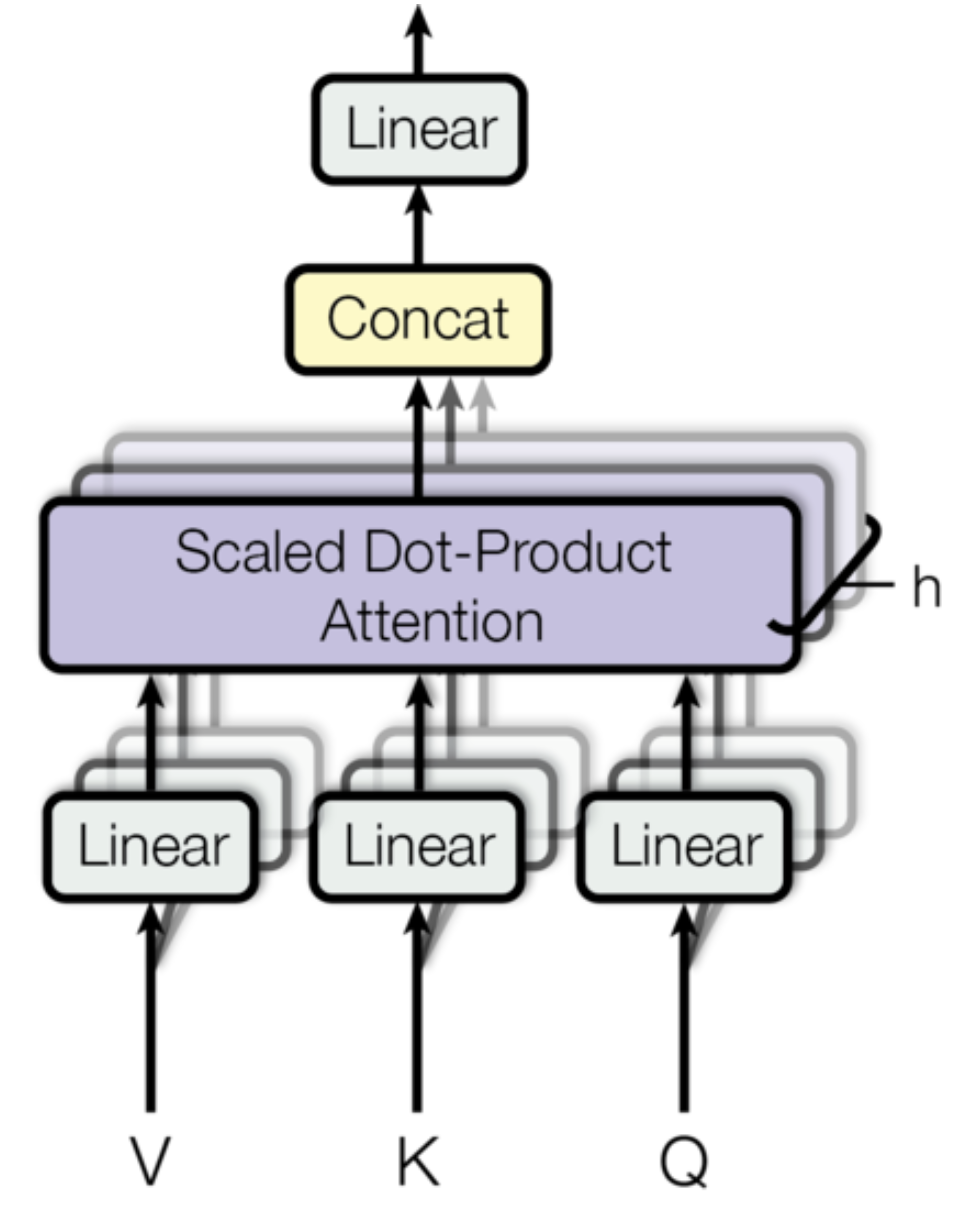

In [11]:
Image(filename='images/multi_head_attention2.png', width=300, unconfined=True)

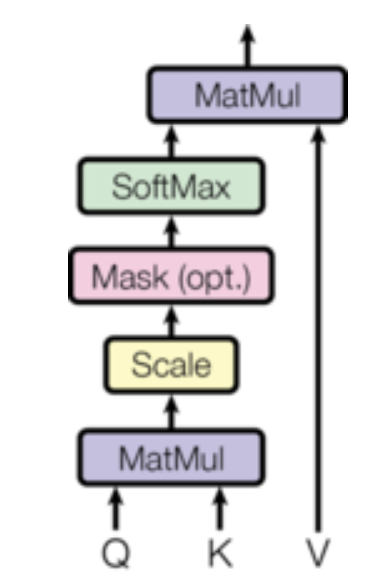

In [12]:
Image(filename='images/self_attention_calculate.png', width=200, unconfined=True)

In [13]:
def subsequent_mask(size):
    """
    decoder这边，在计算self-attention和input/output的attention的时候，只能计算自己前面序列的，后面的不能使用。
    所以使用一个mask函数把后面挡住了。
    """
    attn_shape = (1, size, size)
    # 返回数组的上三角部分。对矩阵进行拷贝，并将第k条对角线下方的元素全部置零。
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


def attention(query, key, value, mask=None, dropout=None):
    """
    计算"Scaled dot product attention"。
    实际上使用矩阵计算，计算都是一些query一起计算
    """
    d_k = query.size(-1)
    #
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        # We assume d_v always equals d_k
        assert d_model % h == 0
        # 在python3中是int除法, d_k是单个head的query,key,value的维度
        self.d_k = d_model // h
        # h是head的个数
        self.h = h
        # 这里的linears感觉应该就是Wq, Wk, Wv这么几个矩阵。
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        # 1) Do all the linear projections in batch from d_model => h x d_k
        # self-attention可以看做是原始输入是一个embedding，但是通过一个self-attention，调整这个embedding的表示。
        # 最初始的query, key, value就是原始的embedding
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear。就是把多头的attention向量搞到一起。
        # 调用view之前最好先contiguous，x.contiguous().view()。因为view需要tensor的内存是整块的
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

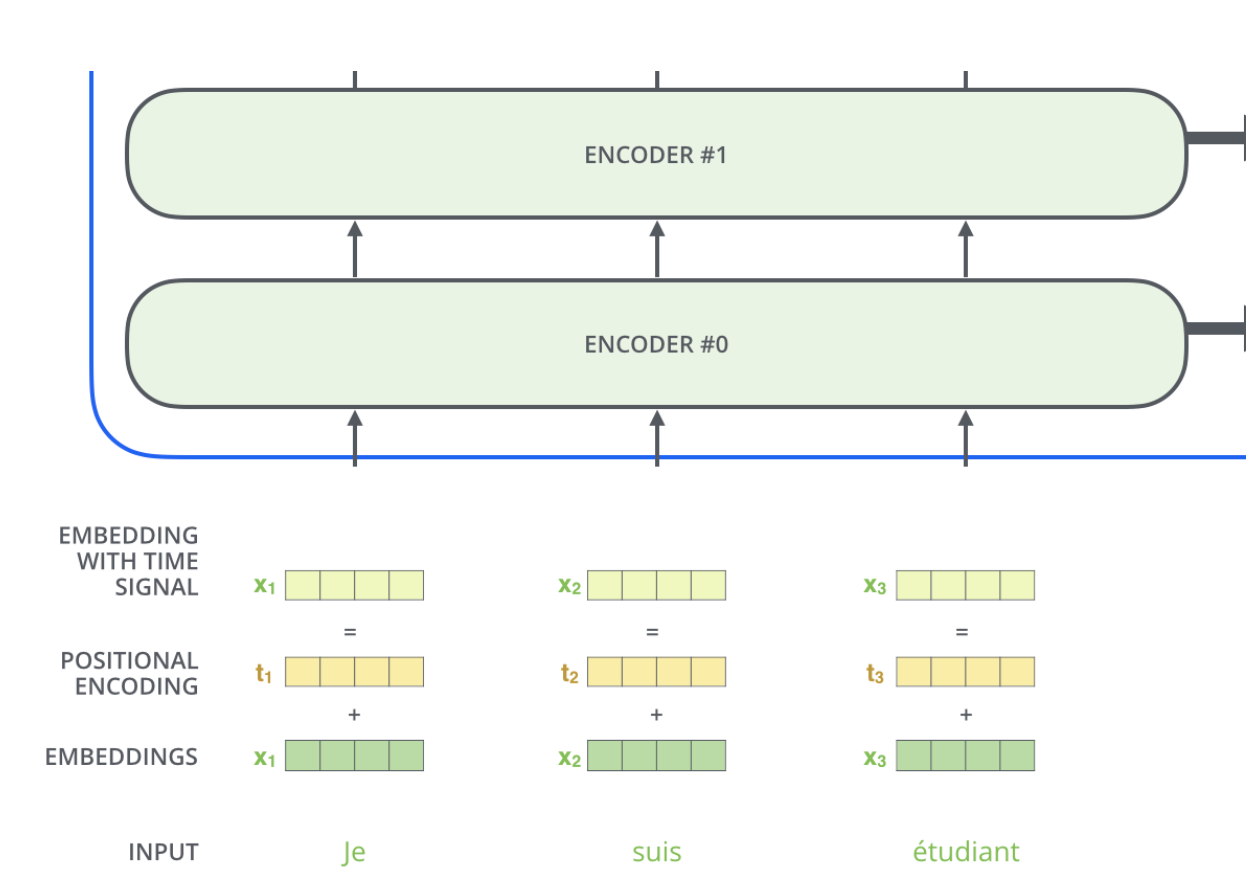

In [14]:
Image(filename='images/embedding_and_positional_encoding.png', width=500, unconfined=True)

In [15]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        """
        d_model就是embedding size。
        这个层在input/output是共享的。
        """
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        # * math.sqrt(self.d_model)这个操作是干啥？
        # 即使对于简单的copy序列的例子，也做了embedding
        return self.lut(x) * math.sqrt(self.d_model)


class PositionalEncoding(nn.Module):
    """
    use sine and cosine functions of different frequencies.
    这个具体到时候再看。
    """
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)


In [16]:
# Full model
"""
src_vocab - source的word dict size
tgt_vocab - target的word dict size
N - encoder和decoder的堆叠层数
d_model - 单个word的encoder的输入维度
"""
def make_model(src_vocab, tgt_vocab, stack_number =2, d_model=256, d_ff=512, h=2, dropout=0.1):
    c = copy.deepcopy
    # encoder/decoder的attention层，2个head，模型的输入size=d_model
    attn = MultiHeadedAttention(h, d_model)
    # encoder/decoder的FFNN层。
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), stack_number),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), stack_number),
        # word embedding + positional encoding
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [17]:
class Batch:
    """
    用来存放一个batch数据的，并且带有mask。
    """
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            # 对于target，返回的是类似tensor([true, false, false...], [true, true, false, false])
            # 表示decoder预测时，只能用到已经看到的token
            self.trg_mask = self.make_std_mask(self.trg, pad)
            # 假设pad用0来表示，这里计算的是实际有效的token
            # self.trg_y != pad 用tensor与0比较，返回类似 tensor([[True, True, True]])
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask


class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))


class LabelSmoothing(nn.Module):
    """
    label smoothing的提出就是为了解决上述问题。最早是在Inception v2中被提出，是一种正则化的策略。其通过"软化"传统的one-hot类型标签
    使得在计算损失值时能够有效抑制过拟合现象。
    具体算法用时再看。
    """
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))


class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        # return loss.data[0] * norm
        return loss.data * norm

# 简答的取最大概率那个
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask,
                           Variable(ys),
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys


In [18]:
def run_epoch(data_iter, model, loss_compute, train=True):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        # if i % 10 == 1:
        #     elapsed = time.time() - start
        #     print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
        #           (i, loss / batch.ntokens, tokens / elapsed))
        #     start = time.time()
        #     tokens = 0
    # if train:
    #     print("Train loss: %f per tokens" % (total_loss / total_tokens))
    # else:
    #     print("Test loss: %f per tokens" % (total_loss / total_tokens))
    return total_loss / total_tokens


#测试transformer效果的例子。
def copy_data_gen(V, batch, nbatches):
    """
    生成batch的数据，每个sample都是一个copy数字例子。
    例如src = [1, 2, 3, 4, 5]
    target = [1, 2, 3, 4,5 ]
    生成一个nbatches组，每组的数据有batch个，长度为10的numpy
    :param V: int数组的上界
    :param batch: 多少个。
    :param nbatches: 每组的个数
    :return:
    """
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src_data = Variable(data, requires_grad=False)
        tgt_data = Variable(data, requires_grad=False)
        yield Batch(src_data, tgt_data, 0)

print("#1 init component")
vocab_size = 11
criterion = LabelSmoothing(size=vocab_size, padding_idx=0, smoothing=0.0)
model = make_model(vocab_size, vocab_size, 2, 128)
model_utils.model_parameters_number(model)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
print(model)
# summary(model, (30, 10))

print("#2 generate data and training")
start = time.time()
n_epochs = 20
for epoch in range(n_epochs):
    # print("epoch - {}".format(epoch))
    # 调用nn.Module.train()会把所有的module设置为训练模式，调用model.eval()会把所有的training属性设置为False。
    # 对于像dropout, batchNorm等操作，train和eval模式的行为有一些不同。
    model.train()
    train_data_iter = copy_data_gen(vocab_size, 30, 20)
    epoch_train_loss = run_epoch(train_data_iter, model, SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    test_data_iter = copy_data_gen(vocab_size, 30, 5)
    epoch_test_loss = run_epoch(test_data_iter, model, SimpleLossCompute(model.generator, criterion, None), False)
    summary = "%s epoch - %s train_loss - %f test_loss - %f" % \
              (time_utils.time_since(start, (epoch + 1) / n_epochs ), epoch + 1, epoch_train_loss, epoch_test_loss)
    print(summary)


print("#3 print some test result")
model.eval()
print_test_data = copy_data_gen(vocab_size, 10, 1)
for i, batch in enumerate(print_test_data):
    src_mask = Variable(torch.ones(1, 1, 10))
    src = batch.src
    for sample in src:
        sample = torch.unsqueeze(sample, 0)
        print("sample - ")
        print(sample)
        print("predict - ")
        print(greedy_decode(model, sample, src_mask, max_len=10, start_symbol=1))


#1 init component
total parameters - 930443, total_trainable_params - 930443
EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=128, out_features=128, bias=True)
            (1): Linear(in_features=128, out_features=128, bias=True)
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=128, out_features=512, bias=True)
          (w_2): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
   

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


(has cost - 0m 2s) ( estimated rest - 0m 39s) epoch - 1 train_loss - 2.633472 test_loss - 2.180158
(has cost - 0m 4s) ( estimated rest - 0m 39s) epoch - 2 train_loss - 2.108710 test_loss - 1.892154
(has cost - 0m 6s) ( estimated rest - 0m 36s) epoch - 3 train_loss - 1.917973 test_loss - 1.676339
(has cost - 0m 8s) ( estimated rest - 0m 33s) epoch - 4 train_loss - 1.771794 test_loss - 1.402144
(has cost - 0m 9s) ( estimated rest - 0m 29s) epoch - 5 train_loss - 1.541926 test_loss - 1.194562
(has cost - 0m 11s) ( estimated rest - 0m 27s) epoch - 6 train_loss - 1.325832 test_loss - 0.731685
(has cost - 0m 14s) ( estimated rest - 0m 26s) epoch - 7 train_loss - 1.055764 test_loss - 0.467879
(has cost - 0m 15s) ( estimated rest - 0m 23s) epoch - 8 train_loss - 0.793718 test_loss - 0.226136
(has cost - 0m 17s) ( estimated rest - 0m 21s) epoch - 9 train_loss - 0.681532 test_loss - 0.221724
(has cost - 0m 19s) ( estimated rest - 0m 19s) epoch - 10 train_loss - 0.588039 test_loss - 0.206028
(has